In [1]:
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

print(tf.__version__)

2.6.3


In [4]:
df = pd.read_csv('train.csv')
models = [tf.keras.models.load_model('model_244_dense')]
models += [tf.keras.models.load_model('model_269_dense')]
models[0].summary()
n_past = [model.input_shape[1] if model.input_shape[1] else len(df) for model in models]

with open('scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)

weeks_to_infer = 2*52  # 2 years
results = df['value'].to_list()
# infer weeks one by one
for i in range(weeks_to_infer):
    print(f'Inferring week {i+1}')
    preds = []
    j = 0
    for model in models:
        x = np.array(results[-n_past[j]:])
        x = scaler.transform(x[-(n_past[j]):].reshape(-1, 1))
        y = model.predict(x.reshape(1, -1, 1))
        preds.append(np.squeeze(scaler.inverse_transform(y)).tolist())
        j += 1
    results.append(np.mean(preds))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 174, 1)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 174)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          22400       flatten[0][0]                    
__________________________________________________________________________________________________
tf.convert_to_tensor (TFOpLambd (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________________

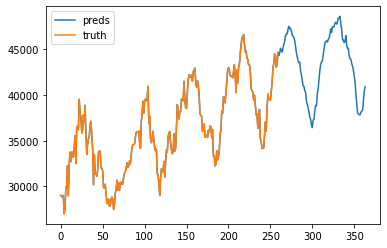

In [5]:
plt.plot(results, label='preds')
plt.plot(df.values, label='truth')
plt.legend()
plt.show()

In [33]:
# save results
preds_only = [round(p) for p in results[-52*2:]]
weeks = [f'2022-{i+1}' for i in range(52)]  # for 2021
weeks += [f'2023-{i+1}' for i in range(52)]  # for 2022
preds_df = pd.DataFrame(data={'week': weeks, 'value': preds_only})
preds_df.to_csv('forecast.csv', index=False)

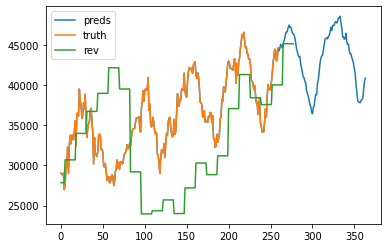

In [29]:
'''
2017Q2: 1 dec 2016 - end feb 2017 4.65
2017Q3: 1 mar 2017 - end may 2017 5.57
2017Q4: 1 jun 2017 - end aug 2017 6.14
2018Q1: 1 sep 2017 - end nov 2017 6.8
2018Q2: 1 dec 2017 - end feb 2018 7.35
2018Q3: 1 mar 2018 - end may 2018 7.8
2018Q4: 1 jun 2018 - end aug 2018 8.44
2019Q1: 1 sep 2018 - end nov 2018 7.91
2019Q2: 1 dec 2018 - end feb 2019 5.84
2019Q3: 1 mar 2019 - end may 2019 4.79
2019Q4: 1 jun 2019 - end aug 2019 4.87
2020Q1: 1 sep 2019 - end nov 2019 5.14
2020Q2: 1 dec 2019 - end feb 2020 4.8
2020Q3: 1 mar 2020 - end may 2020 5.44
2020Q4: 1 jun 2020 - end aug 2020 6.06
2021Q1: 1 sep 2020 - end nov 2020 5.77
2021Q2: 1 dec 2020 - end feb 2021 6.24
2021Q3: 1 mar 2021 - end may 2021 7.42
2021Q4: 1 jun 2021 - end aug 2021 8.27
2022Q1: 1 sep 2021 - end nov 2021 7.69
-------------------------------------------------
2022Q2: 1 dec 2021 - end feb 2022 7.52
2022Q3: 1 mar 2022 - end may 2022 8.01
2022Q4: 1 jun 2022 - end aug 2022 9.04
------- whole of FY2023 total 38.76 -------------
2023Q1: 1 sep 2022 - end nov 2022
2023Q2: 1 dec 2022 - end feb 2023
2023Q3: 1 mar 2023 - end may 2023
2023Q4: 1 jun 2023 - end aug 2023
2024Q1: 1 sep 2023 - end nov 2023
-------------- unknown --------------------------
2024Q2: 1 dec 2023 - end feb 2024
'''



rev = [4.65, 5.57, 6.14, 6.8, 7.35, 7.8, 8.44, 7.91, 5.84, 4.79, 4.87, 5.14, 4.8, 5.44, 6.06, 5.77, 6.24, 7.42, 8.27, 7.69, 7.52, 8.01, 9.04]  # by quarter, from 7.52 onwards is future. last quarter ends aug 31 (week 34), 8.3 is end of FY2021
rev_by_week = [[i] * 13 for i in rev]  # every 3 month ~= 13 weeks
rev_by_week = [i*5000 for sublist in rev_by_week for i in sublist]
del rev_by_week[:4]  # remove first month since FY starts in 1 dec, so remove first 4 weeks
del rev_by_week[:17]  # alignment adjustments

plt.plot(results, label='preds')
plt.plot(df.values, label='truth')
plt.plot(rev_by_week, label='rev')
plt.legend()
plt.show()